# Исследование рынка недвижимости в Санкт-Петербурге

## Описание проекта
В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.2f}'.format)

## Открываем файл с данными и изучаем общую информацию

In [2]:
df = pd.read_csv('real_estate_data.csv', sep='\t')          #для файла на локальной машине
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,...,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,...,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,...,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


Посмотрим на сводку по всем переменным таблицы методом info. Отдельно далее поработаем со столбцами ceiling_height, is_apartment, balcony и остальные, в которых наблюдений меньше общего количества записей 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

А также посмотрим  на числовые характеристики переменных

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,"23,699.00",9.86,5.68,0.00,6.00,9.00,14.00,50.00
last_price,"23,699.00","6,541,548.77","10,887,013.27","12,190.00","3,400,000.00","4,650,000.00","6,800,000.00","763,000,000.00"
total_area,"23,699.00",60.35,35.65,12.00,40.00,52.00,69.90,900.00
rooms,"23,699.00",2.07,1.08,0.00,1.00,2.00,3.00,19.00
ceiling_height,"14,504.00",2.77,1.26,1.00,2.52,2.65,2.80,100.00
floors_total,"23,613.00",10.67,6.60,1.00,5.00,9.00,16.00,60.00
living_area,"21,796.00",34.46,22.03,2.00,18.60,30.00,42.30,409.70
floor,"23,699.00",5.89,4.89,1.00,2.00,4.00,8.00,33.00
kitchen_area,"21,421.00",10.57,5.91,1.30,7.00,9.10,12.00,112.00
balcony,"12,180.00",1.15,1.07,0.00,0.00,1.00,2.00,5.00


В описании есть столбец cityCenters_nearest , это единственный столбец, использующий прописные буквы в названии,будем с ним внимательнее

## Предобработка данных 

In [5]:
df['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

In [6]:
df['is_apartment'] = df['is_apartment'].fillna(False)

Если у квартиры было не указано, что это апартаменты, значит это не апартаменты) заменяем пропущенное False

In [7]:
df['is_apartment'].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

In [8]:
df['ceiling_height'].describe()

count   14,504.00
mean         2.77
std          1.26
min          1.00
25%          2.52
50%          2.65
75%          2.80
max        100.00
Name: ceiling_height, dtype: float64

In [9]:
df['ceiling_height'].median()

2.65

Судя по описанию,у нас есть квартиры с высотой потолка 1 метр и 100 метров!  Судя по базе, квартира площаью 25 квадратов, не может иметь высоту потолков 100 м. Я построила гистограмму распределения высоты потолков с разным количеством корзин, и разным масштабом, и в итоге пришла к выводу, что в данные попала ошибка, предлагаю все значения высоты потолков свыше 5 метров заменить на медианное значение

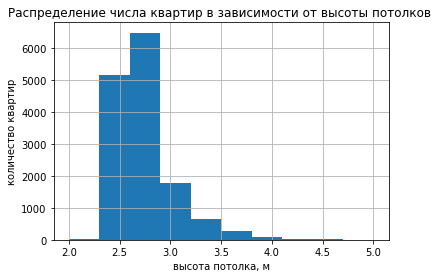

In [10]:
df['ceiling_height'].hist(bins = 10,range=(2,5))
plt.title("Распределение числа квартир в зависимости от высоты потолков ")
plt.xlabel("высота потолка, м")
plt.ylabel("количество квартир")
plt.show()


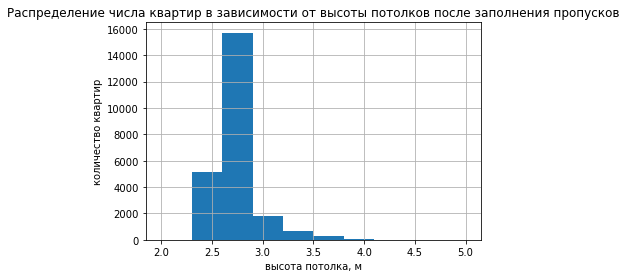

In [11]:
df['ceiling_height'] = df['ceiling_height'].where(df['ceiling_height'] <= 5, 2.65 , axis = 0)
df['ceiling_height'] = df['ceiling_height'].fillna(2.65)
df['ceiling_height'].hist(bins = 10,range=(2,5))
plt.title("Распределение числа квартир в зависимости от высоты потолков после заполнения пропусков")
plt.xlabel("высота потолка, м")
plt.ylabel("количество квартир")
plt.show()

In [12]:
df['ceiling_height'].describe()

count   23,699.00
mean         2.70
std          0.22
min          1.00
25%          2.60
50%          2.65
75%          2.70
max          5.00
Name: ceiling_height, dtype: float64

Проверим, что больше пропущенных значений в высоте потолка нет

In [13]:
df['ceiling_height'].isna().sum()

0

In [14]:
df['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [15]:
df['floors_total'].isna().sum()

86

Заменим отсутствующее значение в floors_total на значение этажа квартиры. Заменить средним значением будет проблематично, тк среднее может оказаться запросто больше, чем указанный этаж. Пропуск мог возникнуть, когда действительно могли забыть, что совпадает и этаж и общее количество этажей (именно для квартир на последнем этаже), или умышленно не указали именно у квартир на последнем этаже этажность дома (остался пережиток о непопулярности квартир последнего этажа, когда квартиры на последнем этаже затапливало из-за плохой крыши, если в доме не было технического этажа).
А так как очень часто клиенты, когда ищут недвиджимость, в параметрах поиска указывают "не последний этаж", то умышленно могут не указывать количество этажей, могут риэлторы, которые хотят, чтобы квартира показывалась в поиске. 
Также надо учесть такое явление, когда квартира находится на последнем этаже , то иногда общее количество этажей может умышленно указываться завышенным.

In [16]:
df[df['floor'] > df['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Нет квартир, у которых указанный этаж выше, чем количество этажей в доме

In [17]:
df['floors_total'].isna().sum()

86

In [18]:
df.dropna(subset=['floors_total'], inplace = True)
df['floors_total'].isna().sum()

0

In [19]:
df[df['floor'] > df['floors_total']]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


поменяем тип переменной - количество этажей, тк это должно быть целое число, а не вещественное

In [20]:
df['floors_total'] = df['floors_total'].astype('int')
display(df['floors_total'].unique() )

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  8,  2, 10,  7, 13, 15, 20, 28, 36, 21, 35, 34, 60,  1, 29, 33,
       52, 37])

In [21]:
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

заменили пропущенное значение балконов на 0, тк если человек не указал наличие балконов, значит их нет. Заменили тип столбца на int, тк количество балконов может быть только целым значением

In [22]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'] = df['balcony'].astype('int')
sorted(df['balcony'].unique())

[0, 1, 2, 3, 4, 5]

In [23]:
df['living_area'].isna().sum()

1870

In [24]:
def fillmedian(square):
    ''' функция считает медиану жилой площади для фиксированного значения общей площади''' 
    return df[df['total_area'] == square]['living_area'].median()


nan_indexes = df.loc[df['living_area'].isna()].index.tolist()
#формируем список индексов строк с пропущенными значениями в жилой площади
for item in nan_indexes:
# заменяем каждое пропущенное медианой по общей площади, указанному в этой же строке    
    df.loc[item,'living_area'] = fillmedian(df.loc[item,'total_area']) 
df['living_area'].isna().sum()

133

Таким образом, снизили число пропусков в значениях жилой площади с 1903 до 133.

Есть столбец с площадью кухни, там 2278 пропусков. заполним пропущенные, как общая - жилая площадь. С чем может быть связан пропуск значения площадь кухни? Возможно с тем, что площадь кухни входит в жилую? То есть это такие квартиры, в которых нет отдельной комнаты кухни, а есть кухонная зона в одной из жилых комнат. Оценим медианные величины: площадь кухни, площадь жилая среди пропущенных значений площади кухни, общую площадь квартиры среди пропущенных, видим что медианная общая площадь квартиры больше на 6 квадратных метров, если бы площадь кухни указывали (что вполне может быть зоной кухни), а медианная жилая площадь больше на 2 квадратных метра (не так существенно). А разница между жилой и общей площадью никак не похожа на медианную площадь кухни (22 квадратных метра против 9), что логично, в эту разницу еще входит площадь санузлов и коридоров. Если оценить разницу между общей и жилой только в строках, где кухня была пропущена, там меньше, всего 18 квадратных метра.
Возьмем среди строк, в которых нет пропусков в столбце кухни, медианную долю, которую занимает кухня от общей площади и умножим на медианную среднюю общую площадь, и тогда получим 8,925 - значение которое мы используем для заполнения пропусков площади кухни.

In [25]:
df['kitchen_area'].median()

9.1

In [26]:
df[df['kitchen_area'].isna()]['living_area'].median()

28.0

In [27]:
df[df['kitchen_area'].isna()]['total_area'].median()

46.0

In [28]:
df['total_area'].median()

52.0

In [29]:
df['living_area'].median()

30.0

In [30]:
df['total_area'].median() - df['living_area'].median()

22.0

In [31]:
df[df['kitchen_area'].isna()]['total_area'].median() - df[df['kitchen_area'].isna()]['living_area'].median()

18.0

добавим отношение площади кухни к общей площади

In [32]:
df['kitchen_part'] = round( df['kitchen_area'] / df['total_area'], 2)

заменим пропуски рассчитанной площадью

In [33]:
kit_area_na = df[~df['kitchen_part'].isna()]['kitchen_part'].median() * df[~df['kitchen_part'].isna()]['total_area'].median()
kit_area_na

8.908000000000001

In [34]:
df['kitchen_area'] = df['kitchen_area'].fillna(kit_area_na)
df['kitchen_area'].isna().sum()

0

In [35]:
df['kitchen_part'] = df['kitchen_part'].fillna(df['kitchen_part'].median())

In [36]:
df['ponds_around3000'].isna().sum()

5508

In [37]:
df['parks_around3000'].isna().sum()

5508

Если в столбце количество водоемов, количество парков стоит пропуск, то это означает, что скорее всего водоемов и парков рядом нет, пропущенные надо заменить нулем

In [38]:
display(df['ponds_around3000'].isna().sum() )
display(df['parks_around3000'].isna().sum())

5508

5508

Расстояние до парков и водоемов вычислялось автоматически, мы никак не можем убрать пропуски, к сожалению.

In [39]:
display( df['ponds_nearest'].isna().sum() )
display (df['parks_nearest'].isna().sum() )

14552

15568

Удалим строки, содержащие пропущенные значения в locality_name , тк заменить их никак нельзя. Но их не так много, всего 49 строчек из более 23 тысяч

In [40]:
df['locality_name'].isna().sum()

48

In [41]:
df.dropna(subset = ['locality_name'], inplace = True)
df['locality_name'].isna().sum()

0

Пропусков в значениях жилой площади 133 строчки, заменим пропуск, умножив среднюю долю на общую площадь

In [42]:
df['living_area'].isna().sum()

133

добавим в таблицу отношение жилой площади к общей

In [43]:
df['living_part'] = round(df['living_area'] / df['total_area'] ,2)  


In [44]:
df['living_area'].median()

30.0

In [45]:
df['living_part'].median()*df['total_area'].median()

29.639999999999997

In [46]:
df['living_area'] = df['living_area'].fillna(df['living_part'].median()*df['total_area'].median())
df['living_area'].isna().sum()

0

In [47]:
df['living_part'] = df['living_part'].fillna(df['living_part'].median())

## Добавление дополнительной информации

Добавим в таблицу информацию о цене квадратного метра square_amount - поделим цену на момент снятия с публикации на общую площадь

In [48]:
df['square_amount'] = round(df['last_price'] / df['total_area'] , 2)

In [49]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

добавим в таблицу отдельно информацию про год, месяц и день недели создания объявления

In [50]:
df['first_day'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['weekday']=pd.DatetimeIndex(df['first_day_exposition']).weekday

напишем функцию которая анализирует этаж квартиры, первый последний другой

In [51]:
def what_floor(row):
    ''' Функция по значению этажа присваивает категорию'''
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == row['floors_total']:
        return 'последний'
    return 'другой'

добавим столбец про этаж, первый последний и другой:

In [52]:
df['what_floor'] = df.apply(what_floor, axis = 1) 
df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16,51.00,8,False,...,755.00,NaN,0.23,0.47,"120,370.37",2019-03-07,2019,3,3,другой
1,7,"3,350,000.00",40.40,2018-12-04,1,2.65,11,18.60,1,False,...,NaN,81.00,0.27,0.46,"82,920.79",2018-12-04,2018,12,1,первый
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5,34.30,4,False,...,574.00,558.00,0.15,0.61,"92,785.71",2015-08-20,2015,8,3,другой
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14,95.00,9,False,...,234.00,424.00,0.17,0.60,"408,176.10",2015-07-24,2015,7,4,другой
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14,32.00,13,False,...,48.00,121.00,0.41,0.32,"100,000.00",2018-06-19,2018,6,1,другой


## Исследовательский анализ данных

Количество комнат в квартирах варьируется от 0 до 19, но и площадь в этом случае варьируется достаточно сильно, можно оценить отношение общей площади к количеству комнат(среди тех данных, где число комнат не равно нулю), и тогда средняя площадь 1 комнаты будет составлять около 30 квадратных метров (что в целом ожидаемо).

Можно предложить поменять в квартирах,в которых число комнат выставлено = 0, значение количества комнат на 1, тк это было бы логично?

In [53]:
df['rooms'].describe()

count   23,565.00
mean         2.07
std          1.08
min          0.00
25%          1.00
50%          2.00
75%          3.00
max         19.00
Name: rooms, dtype: float64

In [54]:
df['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12],
      dtype=int64)

In [55]:
df['aver_square_per_room']=df[df['rooms']!=0]['total_area'] / df[df['rooms']!=0]['rooms']
df['aver_square_per_room'].describe()

count   23,371.00
mean        30.81
std          9.74
min          8.00
25%         23.70
50%         30.00
75%         36.00
max        494.10
Name: aver_square_per_room, dtype: float64

In [56]:
df['aver_square_per_room'].median()

30.0

In [57]:
df[df['rooms']>10]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor,aver_square_per_room
648,3,"17,500,000.00",183.70,2018-07-01,11,3.40,7,138.80,7,False,...,NaN,0.07,0.76,"95,264.02",2018-07-01,2018,7,6,последний,16.70
866,5,"25,000,000.00",363.00,2017-12-23,14,3.16,5,222.00,4,False,...,418.00,0.05,0.61,"68,870.52",2017-12-23,2017,12,5,другой,25.93
5358,20,"65,000,000.00",590.00,2019-02-14,15,3.50,6,409.00,3,False,...,14.00,0.17,0.69,"110,169.49",2019-02-14,2019,2,3,другой,39.33
9688,8,"33,000,000.00",194.10,2017-02-07,11,3.43,5,129.00,2,False,...,813.00,0.06,0.66,"170,015.46",2017-02-07,2017,2,1,другой,17.65
14498,6,"32,250,000.00",374.60,2018-06-09,19,2.65,5,264.50,2,False,...,114.00,0.07,0.71,"86,091.83",2018-06-09,2018,6,5,другой,19.72
18848,6,"28,500,000.00",270.00,2015-03-02,16,3.00,4,180.00,4,False,...,"1,365.00",0.05,0.67,"105,555.56",2015-03-02,2015,3,0,последний,16.88
19540,8,"420,000,000.00",900.00,2017-12-06,12,2.80,25,409.70,25,False,...,106.00,0.12,0.46,"466,666.67",2017-12-06,2017,12,2,последний,75.00
20829,6,"28,659,000.00",245.40,2016-03-31,14,2.65,4,168.30,2,False,...,95.00,0.11,0.69,"116,784.84",2016-03-31,2016,3,3,другой,17.53


In [58]:
df[df['rooms']==0]['total_area'].unique()

array([ 27.  ,  25.  ,  27.11,  34.4 ,  24.1 ,  17.  ,  26.1 ,  35.  ,
        23.  ,  29.  ,  32.  ,  26.  ,  31.  ,  22.  ,  30.  ,  23.98,
        27.55,  27.1 ,  28.4 ,  26.49,  28.9 ,  24.  ,  73.6 ,  21.4 ,
        29.3 ,  28.  ,  20.  ,  19.5 ,  27.81,  26.8 ,  32.3 ,  42.63,
        29.2 ,  27.3 ,  21.3 ,  19.  ,  18.8 ,  15.5 ,  38.3 ,  16.  ,
        23.4 ,  27.56,  24.8 ,  28.3 ,  23.7 ,  44.2 ,  24.75,  20.5 ,
        29.1 ,  26.7 ,  25.27,  27.32,  23.06,  23.5 ,  32.4 ,  21.  ,
        24.2 ,  18.  ,  24.9 ,  58.4 ,  28.2 ,  24.05,  24.4 ,  25.2 ,
        43.3 ,  27.4 ,  23.3 ,  32.2 ,  32.03,  25.7 ,  42.1 ,  22.3 ,
        28.01,  32.8 ,  26.23,  25.3 ,  28.05,  31.1 ,  22.5 ,  25.9 ,
        32.5 ,  23.8 , 371.  ,  24.6 ,  30.5 ,  25.41,  98.4 ,  23.6 ,
        22.2 ,  27.5 ,  28.16,  27.6 ,  71.  ,  28.5 ,  24.5 ,  22.7 ,
        34.  ,  30.1 ,  27.7 ,  26.05,  23.39])

Посмотрим на характеристики показателя общей площади. 75% значений попадают в диапазон < 69.7 квадратных метров, при этом среднее значение 60 квадратных метров. Но в данных есть и очень большие квартиры по площади, так как максимальное значение 900 квадратных метров, например находятся 61 объект недвижимости с площаью свыше 300 квадратных метров, от общего числа записей это примерно 0,3% от общего размера таблицы. Минимальное занчение площади квартиры - 12 квадратных метров,что вполне сопоставимо с реальностью - такие маленькие квартиры действительно существуют)

In [59]:
df['total_area'].describe()

count   23,565.00
mean        60.32
std         35.66
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64

In [60]:
df[df['total_area']>300]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor,aver_square_per_room
155,8,"96,000,000.00",317.00,2017-07-07,4,3.50,3,183.00,3,False,...,62.00,0.17,0.58,"302,839.12",2017-07-07,2017,7,4,последний,79.25
581,20,"65,000,000.00",365.00,2019-03-18,7,2.90,7,101.00,7,False,...,NaN,0.17,0.28,"178,082.19",2019-03-18,2019,3,0,последний,52.14
660,3,"49,950,000.00",483.90,2017-10-04,7,3.20,6,312.50,4,False,...,391.00,0.05,0.65,"103,223.81",2017-10-04,2017,10,2,другой,69.13
793,20,"135,000,000.00",310.00,2018-05-22,4,3.30,5,250.00,2,False,...,342.00,0.16,0.81,"435,483.87",2018-05-22,2018,5,1,другой,77.50
866,5,"25,000,000.00",363.00,2017-12-23,14,3.16,5,222.00,4,False,...,418.00,0.05,0.61,"68,870.52",2017-12-23,2017,12,5,другой,25.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20820,7,"73,900,000.00",342.00,2015-06-18,5,2.65,4,187.00,2,False,...,377.00,0.03,0.55,"216,081.87",2015-06-18,2015,6,3,другой,68.40
21955,19,"130,000,000.00",431.00,2017-10-02,7,3.70,8,220.00,5,False,...,161.00,0.05,0.51,"301,624.13",2017-10-02,2017,10,0,другой,61.57
21990,20,"68,000,000.00",373.10,2018-09-08,8,2.65,8,176.20,8,False,...,234.00,0.08,0.47,"182,256.77",2018-09-08,2018,9,5,последний,46.64
22131,14,"27,000,000.00",422.20,2018-10-18,5,2.70,13,29.64,11,False,...,NaN,0.17,0.57,"63,950.73",2018-10-18,2018,10,3,другой,84.44


Чтобы оценить цены, посмотрим на стоимость квадратного метра, она варьируется от 111 рублей (???) до 1 907 500 р(???). Но средняя стоимость составляет порядка 99, 5 тысяч рублей за квадратный метр, это вполне ожидаемо, и сопоставимо с медианным значением в 95 тысяч.

In [61]:
df['square_amount'].describe()

count      23,565.00
mean       99,405.84
std        50,389.43
min           111.83
25%        76,566.13
50%        95,000.00
75%       114,213.20
max     1,907,500.00
Name: square_amount, dtype: float64

In [62]:
df['square_amount'].median()

95000.0

In [63]:
df['airports_nearest'].describe()

count   18,041.00
mean    28,797.08
std     12,632.50
min          0.00
25%     18,565.00
50%     26,757.00
75%     37,273.00
max     84,869.00
Name: airports_nearest, dtype: float64

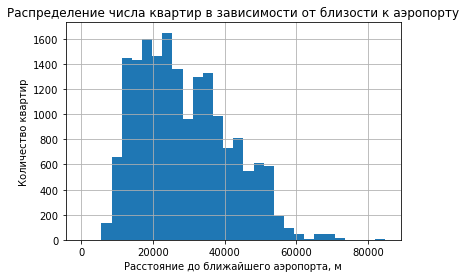

In [64]:
df['airports_nearest'].hist(bins = 30)
plt.title("Распределение числа квартир в зависимости от близости к аэропорту")
plt.xlabel("Расстояние до ближайшего аэропорта, м")
plt.ylabel("Количество квартир")
plt.show()

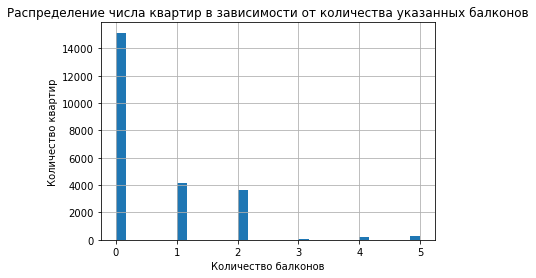

In [65]:
df['balcony'].hist(bins = 30)
plt.title("Распределение числа квартир в зависимости от количества указанных балконов")
plt.xlabel("Количество балконов")
plt.ylabel("Количество квартир")
plt.show()

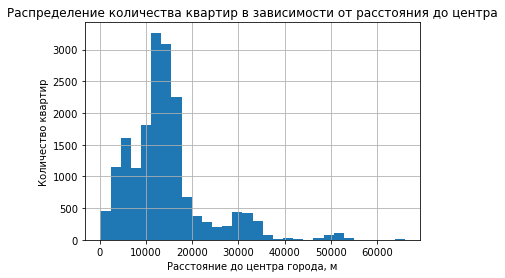

In [66]:
df['cityCenters_nearest'].hist(bins = 30)
plt.title("Распределение количества квартир в зависимости от расстояния до центра")
plt.xlabel("Расстояние до центра города, м")
plt.ylabel("Количество квартир")
plt.show() 

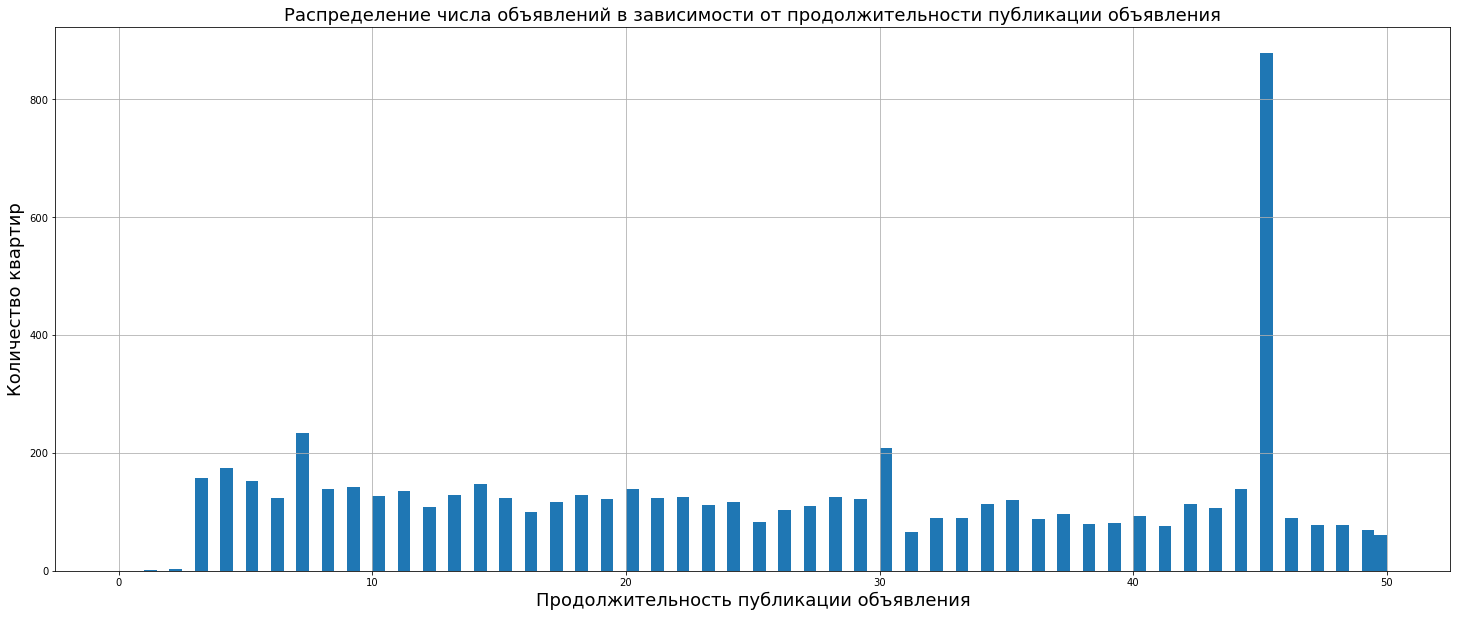

In [67]:
df['days_exposition'].hist(bins = 100,figsize=(25,10),range=(0,50))
plt.title("Распределение числа объявлений в зависимости от продолжительности публикации объявления", fontsize=18)
plt.xlabel("Продолжительность публикации объявления", fontsize=18)
plt.ylabel("Количество квартир", fontsize=18)
plt.show() 

При количестве корзин менее 50 (на всем диапазоне значений столбца) распределение времени продажи квартиры сильно напоминает пуассоновское распределение, но если увеличить число корзин до 110, то явно появляется второй пик, он возникает при значении примерно в 40 дней, если мы посмотрим только количество дней размещения объявления на диапазоне от 0 до 200 дней, то четко ловим максимум в 45 дней. 

In [68]:
df['days_exposition'].describe()

count   20,394.00
mean       180.74
std        219.73
min          1.00
25%         45.00
50%         95.00
75%        231.00
max      1,580.00
Name: days_exposition, dtype: float64

In [69]:
df['days_exposition'].mode()

0   45.00
Name: days_exposition, dtype: float64

In [70]:
df['days_exposition'].value_counts()

45.00       879
60.00       538
7.00        234
30.00       208
90.00       200
           ... 
964.00        1
1,147.00      1
1,228.00      1
1,112.00      1
971.00        1
Name: days_exposition, Length: 1139, dtype: int64

Если посмотреть на числовые характеристики, то есть конечно уникальные случаи, когда объявление снималось с публикации спустя 1 сутки, и есть очень долгие продажи (4,3 года??? ), но самое частое значение - это 45 дней (мода) (порядка 4 % от всех объявлений) , несмотря на то, что медиана переменной 95 дней, а среднее значение вообще 180 дней! Tо есть чаще всего объявление о продаже квартиры "живет" полтора месяца, и все объявления, срок жизни которых сильно отличается, нужно изучать внимательнее и возможно, редактировать.

Пик есть на 7 дней (неделя), и на 30 дней (месяц) , возможно в настройках яндекс недвижимости есть опция - публикация на неделю или на месяц, после которой автопродление публикации могло быть выключено, и поэтому объявление закрывалось. Мне необходима доп информация, чтобы проверить эту гипотезу)

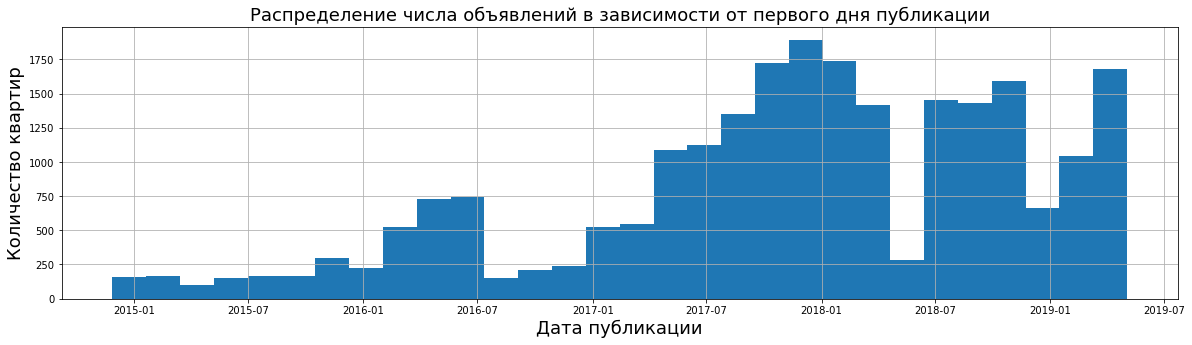

In [71]:
df['first_day_exposition'].hist(bins = 30,figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от первого дня публикации", fontsize=18)
plt.xlabel("Дата публикации", fontsize=18)
plt.ylabel("Количество квартир", fontsize=18)
plt.show()  

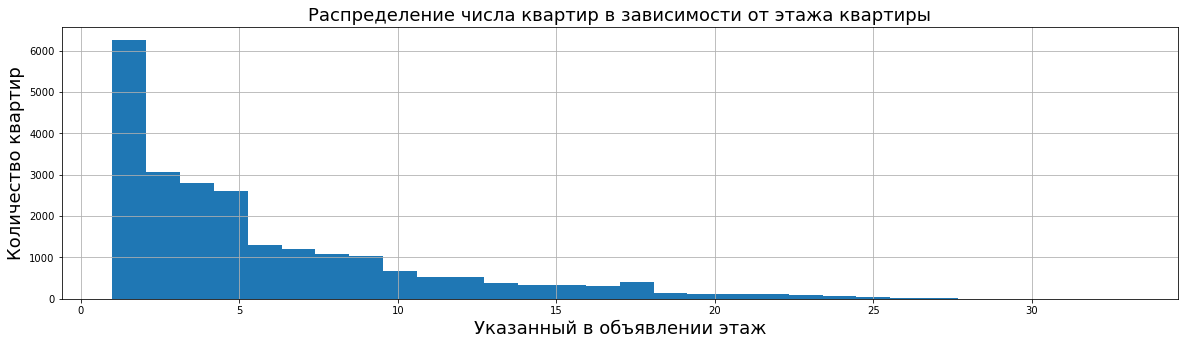

In [72]:
df['floor'].hist(bins = 30,figsize=(20,5))
plt.title("Распределение числа квартир в зависимости от этажа квартиры", fontsize=18)
plt.xlabel("Указанный в объявлении этаж", fontsize=18)
plt.ylabel("Количество квартир", fontsize=18)
plt.show()  

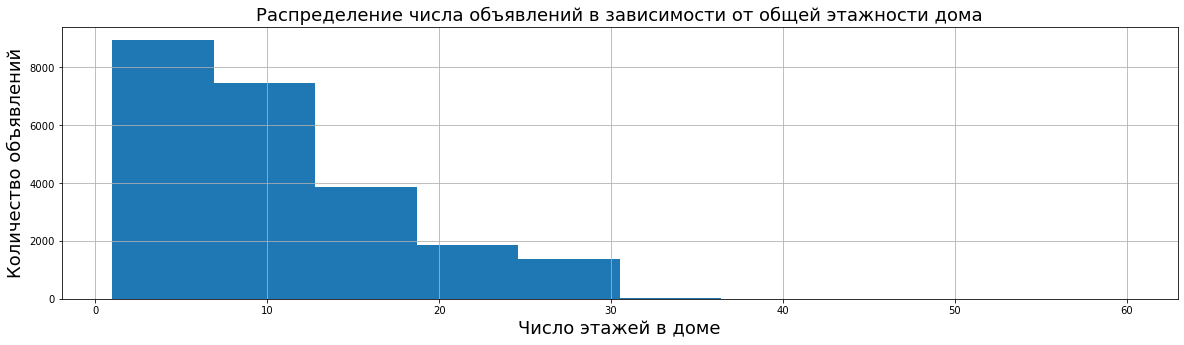

In [73]:
df['floors_total'].hist(figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от общей этажности дома", fontsize=18)
plt.xlabel("Число этажей в доме", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

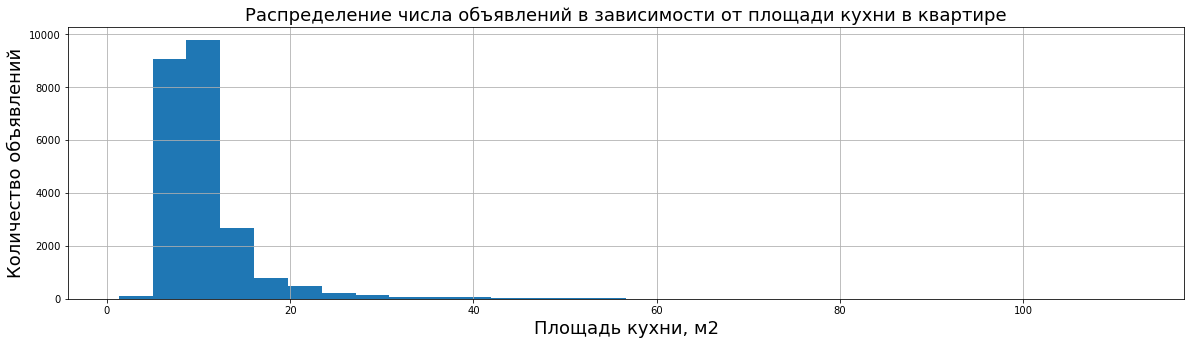

In [74]:
df['kitchen_area'].hist(bins = 30,figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от площади кухни в квартире", fontsize=18)
plt.xlabel("Площадь кухни, м2", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

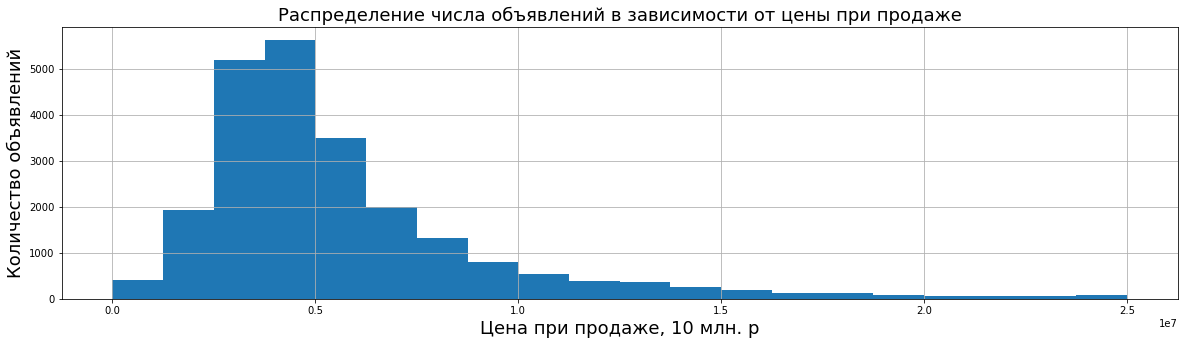

In [75]:
df['last_price'].hist(bins = 20,figsize=(20,5), range=(0, 25_000_000))
plt.title("Распределение числа объявлений в зависимости от цены при продаже", fontsize=18)
plt.xlabel("Цена при продаже, 10 млн. р", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

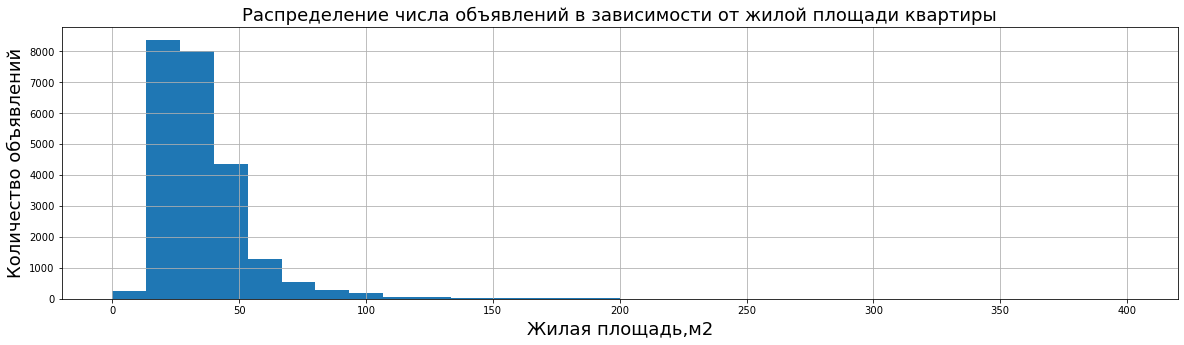

In [76]:
df['living_area'].hist(bins = 30,figsize=(20,5), range=(0,400))
plt.title("Распределение числа объявлений в зависимости от жилой площади квартиры", fontsize=18)
plt.xlabel("Жилая площадь,м2", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

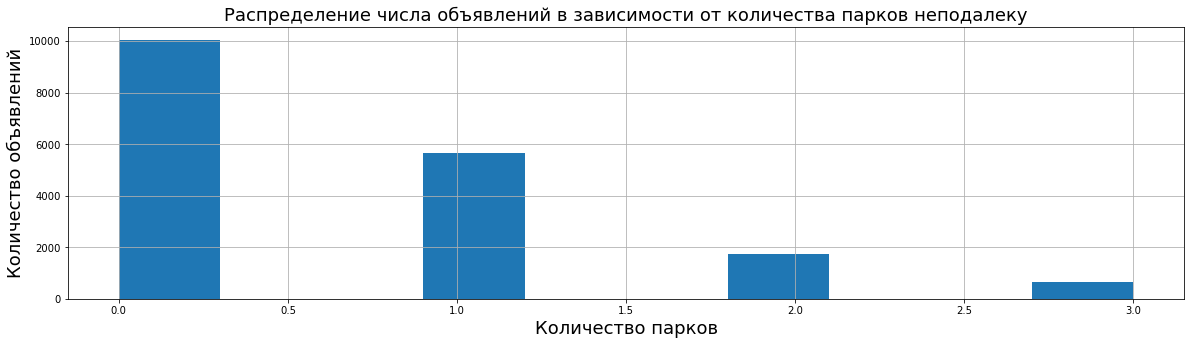

In [77]:
df['parks_around3000'].hist(figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от количества парков неподалеку", fontsize=18)
plt.xlabel("Количество парков", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

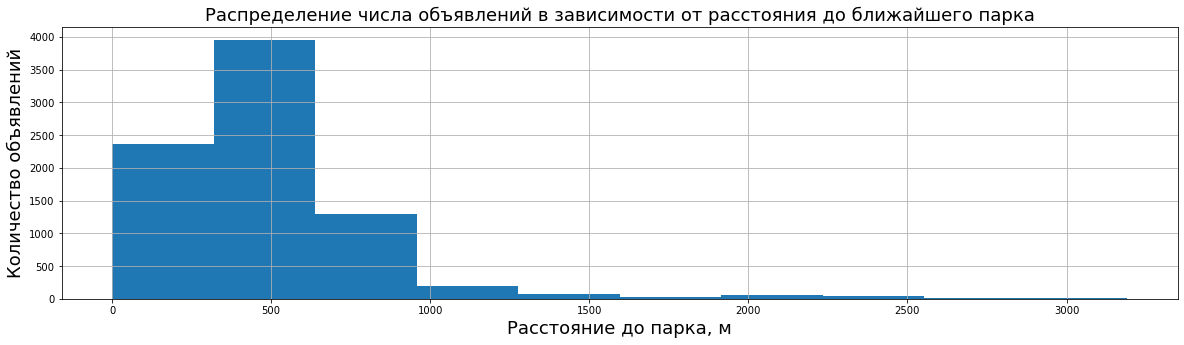

In [78]:
df['parks_nearest'].hist(figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от расстояния до ближайшего парка", fontsize=18)
plt.xlabel("Расстояние до парка, м", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

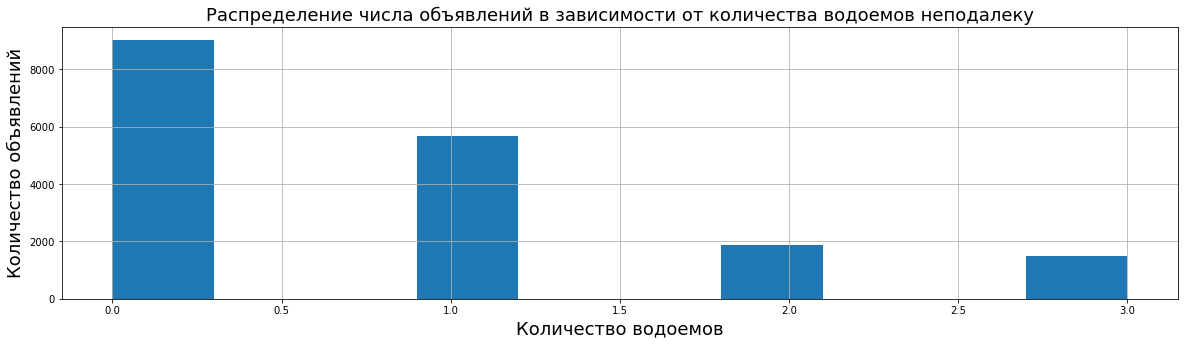

In [79]:
df['ponds_around3000'].hist(figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от количества водоемов неподалеку", fontsize=18)
plt.xlabel("Количество водоемов", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

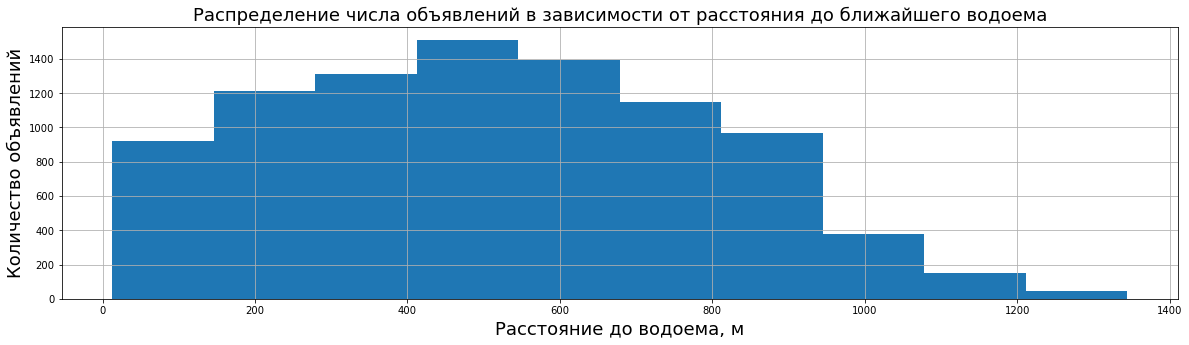

In [80]:
df['ponds_nearest'].hist(bins=10,figsize=(20,5))
plt.title("Распределение числа объявлений в зависимости от расстояния до ближайшего водоема", fontsize=18)
plt.xlabel("Расстояние до водоема, м", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

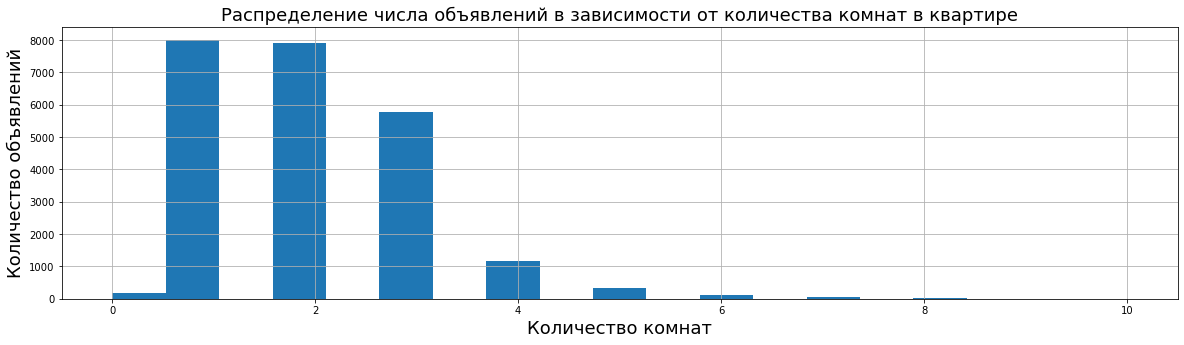

In [81]:
df['rooms'].hist(bins=19,figsize=(20,5), range=(0,10))
plt.title("Распределение числа объявлений в зависимости от количества комнат в квартире", fontsize=18)
plt.xlabel("Количество комнат", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

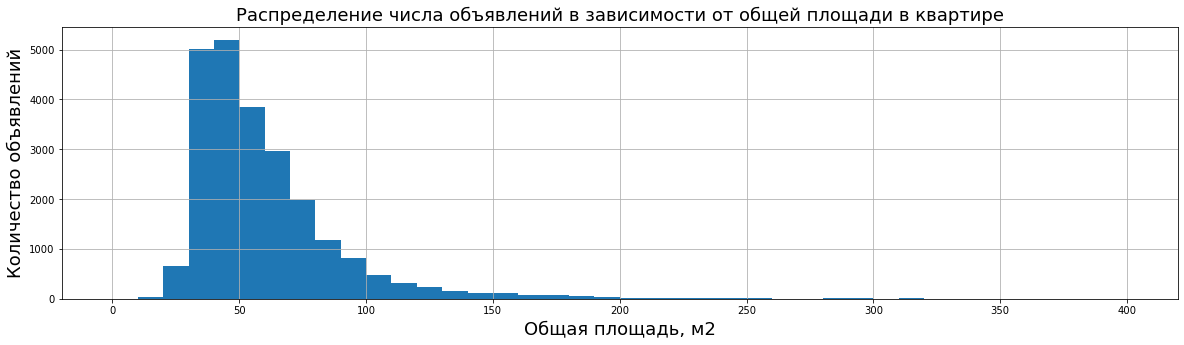

In [82]:
df['total_area'].hist(bins=40,figsize=(20,5), range = (0,400))
plt.title("Распределение числа объявлений в зависимости от общей площади в квартире", fontsize=18)
plt.xlabel("Общая площадь, м2", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show() 

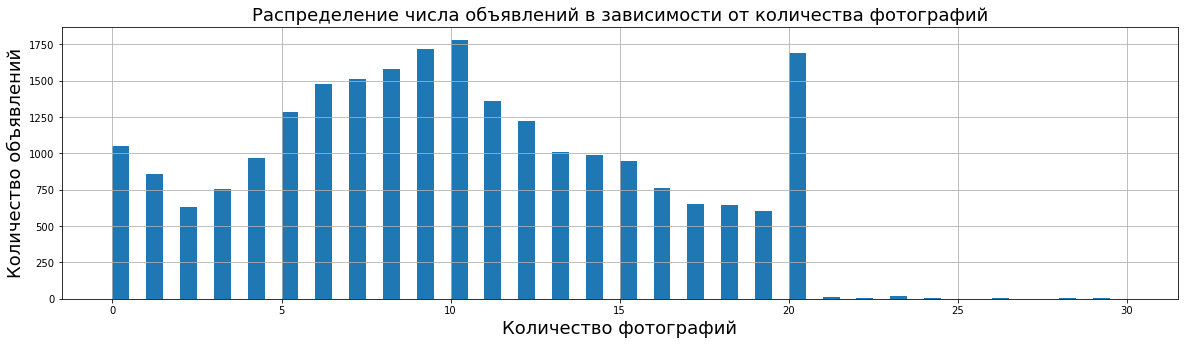

In [83]:
df['total_images'].hist(bins=60,figsize=(20,5),range = (0,30))
plt.title("Распределение числа объявлений в зависимости от количества фотографий", fontsize=18)
plt.xlabel("Количество фотографий", fontsize=18)
plt.ylabel("Количество объявлений", fontsize=18)
plt.show()

In [84]:
(df.corr().round(3).style.bar( align='mid',
      color=['coral', 'yellowgreen'],
      vmin=-1,
      vmax=1
     )
)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_part,living_part,square_amount,year,month,weekday,aver_square_per_room
total_images,1.000000,0.105000,0.117000,0.100000,0.052000,0.010000,0.105000,0.033000,0.010000,-0.028000,-0.025000,0.109000,0.047000,-0.003000,-0.048000,0.021000,-0.006000,-0.011000,-0.004000,-0.027000,-0.017000,-0.001000,0.133000,0.139000,0.004000,-0.009000,0.020000
last_price,0.105000,1.000000,0.654000,0.363000,0.280000,-0.007000,0.554000,0.027000,0.027000,-0.025000,-0.009000,0.440000,0.009000,-0.026000,-0.206000,0.151000,-0.017000,0.161000,-0.086000,0.081000,-0.075000,0.007000,0.737000,-0.043000,0.003000,0.001000,0.273000
total_area,0.117000,0.654000,1.000000,0.759000,0.390000,-0.075000,0.906000,-0.024000,0.030000,-0.072000,-0.035000,0.570000,0.010000,-0.030000,-0.231000,0.166000,-0.021000,0.164000,-0.100000,0.150000,-0.294000,0.142000,0.303000,-0.079000,0.005000,-0.006000,0.236000
rooms,0.100000,0.363000,0.759000,1.000000,0.247000,-0.228000,0.834000,-0.151000,0.000000,-0.146000,-0.088000,0.259000,-0.016000,-0.061000,-0.184000,0.138000,-0.054000,0.094000,-0.060000,0.127000,-0.547000,0.471000,0.056000,-0.054000,-0.004000,-0.005000,-0.361000
ceiling_height,0.052000,0.280000,0.390000,0.247000,1.000000,-0.084000,0.375000,-0.046000,0.068000,0.004000,-0.002000,0.323000,-0.043000,-0.081000,-0.297000,0.225000,-0.057000,0.191000,-0.110000,0.112000,-0.007000,-0.001000,0.285000,-0.051000,-0.003000,-0.023000,0.205000
floors_total,0.010000,-0.007000,-0.075000,-0.228000,-0.084000,1.000000,-0.162000,0.678000,-0.026000,0.070000,0.051000,0.151000,0.173000,0.109000,0.019000,-0.252000,0.098000,-0.123000,0.040000,-0.052000,0.326000,-0.351000,0.148000,0.008000,0.017000,0.013000,0.258000
living_area,0.105000,0.554000,0.906000,0.834000,0.375000,-0.162000,1.000000,-0.093000,0.032000,-0.056000,-0.031000,0.407000,-0.011000,-0.054000,-0.229000,0.182000,-0.048000,0.148000,-0.083000,0.146000,-0.450000,0.417000,0.224000,-0.075000,0.002000,-0.006000,0.007000
floor,0.033000,0.027000,-0.024000,-0.151000,-0.046000,0.678000,-0.093000,1.000000,-0.013000,0.036000,0.036000,0.127000,0.172000,0.073000,0.008000,-0.164000,0.073000,-0.076000,0.026000,-0.039000,0.229000,-0.255000,0.129000,0.005000,0.021000,0.011000,0.202000
is_apartment,0.010000,0.027000,0.030000,0.000000,0.068000,-0.026000,0.032000,-0.013000,1.000000,-0.004000,-0.002000,0.038000,0.033000,0.017000,0.004000,0.021000,-0.034000,0.024000,0.003000,0.015000,0.018000,0.005000,0.045000,0.009000,0.002000,-0.009000,0.048000
studio,-0.028000,-0.025000,-0.072000,-0.146000,0.004000,0.070000,-0.056000,0.036000,-0.004000,1.000000,-0.004000,-0.021000,0.030000,-0.022000,-0.007000,-0.031000,0.007000,0.001000,0.002000,-0.022000,-0.018000,0.088000,0.016000,0.011000,-0.001000,-0.001000,-0.008000


Корреляционная матрица не позволяет наглядно понять, где сильные, а где слабые связи, поэтому построим тепловую карту по корреляционной матрице и поищем связи там. 

<AxesSubplot:title={'center':'Связь переменных'}>

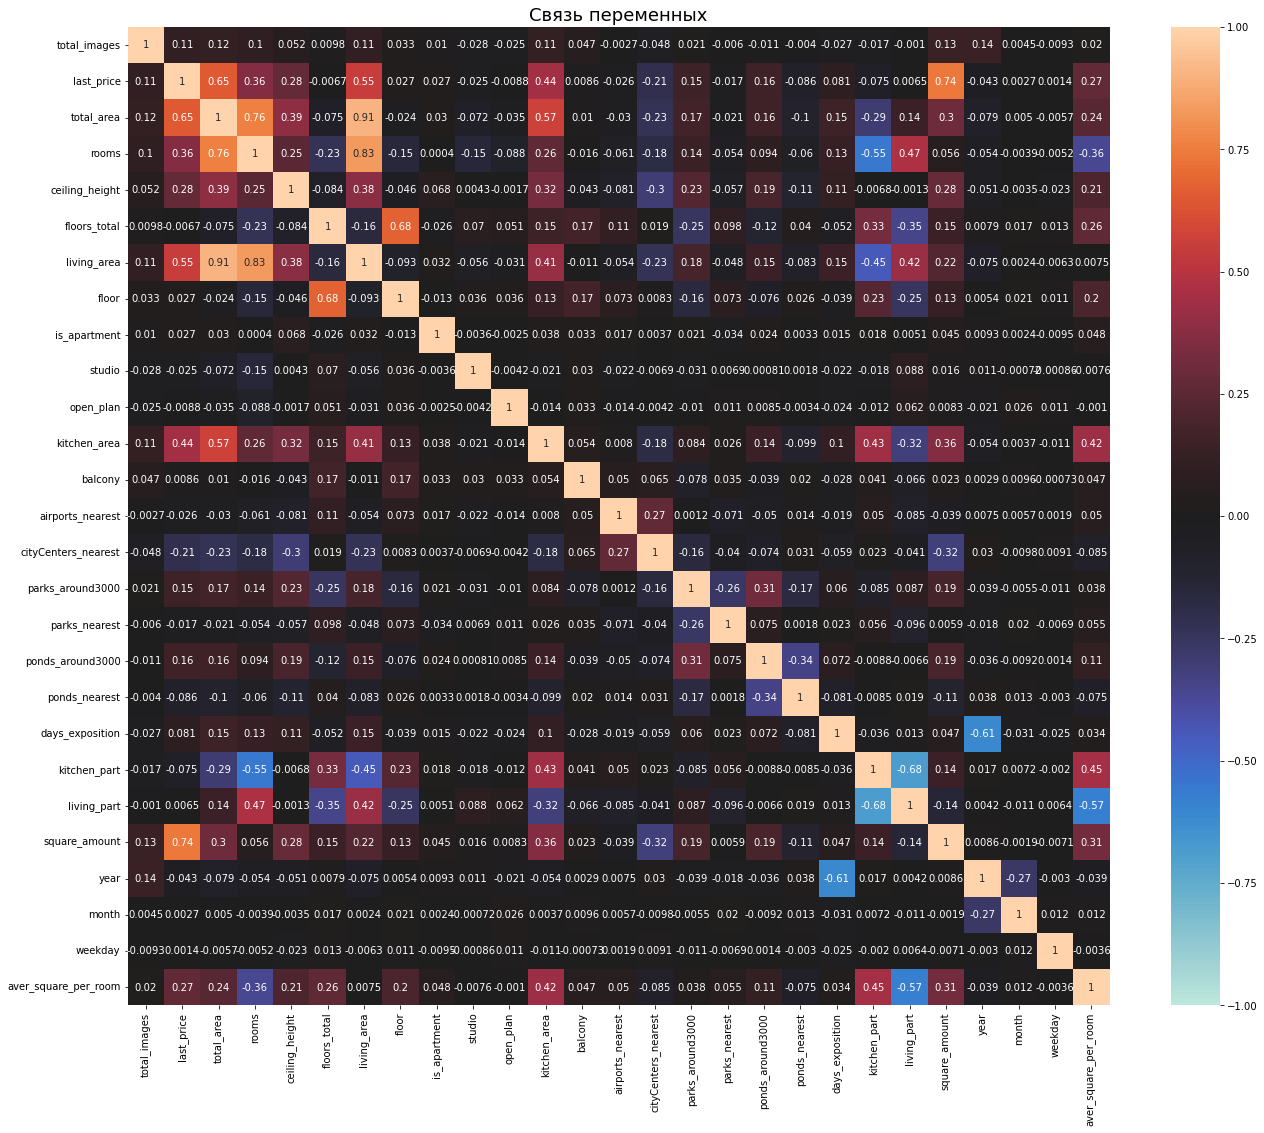

In [85]:
plt.figure(figsize=(22, 18))
plt.title("Связь переменных", fontsize=18)

sb.heatmap(df.corr(),annot = True,fmt='.2g',vmin=-1, vmax=1, center= 0)

В итоге, можно сделать вывод, что цена квартиры зависит от общей площади квартиры (чем больше площадь, тем больше цена, коэффициент корреляции 0,65), а также слабая положительная корреляция от высоты потолка и числа комнат.
Точнее оценивать влияние на цену нужно через переменную стоимость за квадратный метр, и тогда мы видим  отрицательную слабую связь с расстоянием до центра (что логично, чем дальше от центра, тем дешевле квартира), слабую положительную связь с количеством парков и прудов рядом (наличие таких объектов повышает цену), с площадью кухни (чем больше кухня, тем выше цена за квадрат, но связь слабая, коэф-т корреляции 0,36), ну и высотой потолков, чем выше потолки, тем больше ценится квартира.

Связь цены перед продажей с стоимостью квадратного метра очевидна, и не дает дополнительных выводов

Text(0, 0.5, 'Цена за квадратный метр, р')

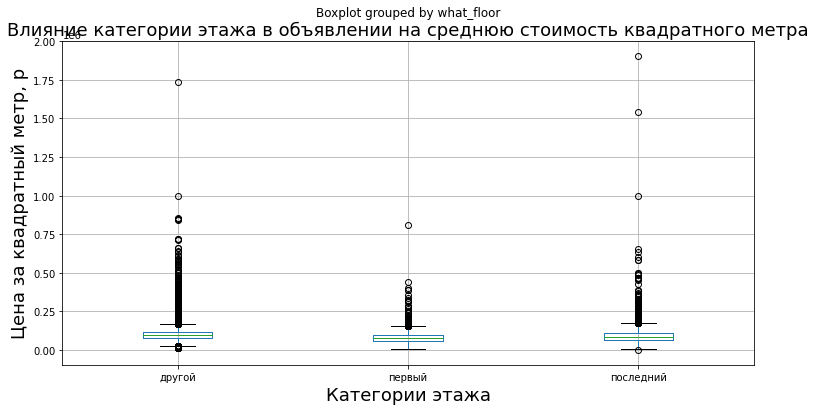

In [86]:
df.boxplot(column = 'square_amount', by = 'what_floor',figsize=(12, 6))
plt.title("Влияние категории этажа в объявлении на среднюю стоимость квадратного метра", fontsize=18)
plt.xlabel("Категории этажа", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)


In [87]:
df.groupby(['what_floor']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                             \
                    mean    median       min          max       std   
what_floor                                                            
другой        103,486.32 98,288.07 10,368.66 1,736,842.11 47,661.02   
первый         82,001.61 81,250.00  9,615.38   813,253.01 38,249.37   
последний      93,378.96 87,763.15    111.83 1,907,500.00 66,971.55   

                             
                        var  
what_floor                   
другой     2,271,572,837.63  
первый     1,463,014,542.15  
последний  4,485,187,932.95

Как видно из таблицы выше, стоимость квартиры за квадратный метр зависит действительно от этажа квартиры, менее всего ценятся квартиры на 1 этаже (судя по среднему и медиане), затем идут по стоимости квартиры на последнем этаже, и больше всего ценятся квартиры не на крайних этажах, поэтому да, можно сделать вывод, что этаж влияет на стоимость квартиры

In [88]:
df.groupby(['what_floor']).agg({'last_price':['mean', 'median','min', 'max', 'std', 'var']})

last_price                                                       \
                   mean       median        min            max           std   
what_floor                                                                     
другой     6,674,348.90 4,848,500.00 450,000.00 330,000,000.00  8,630,829.52   
первый     4,802,603.99 3,900,000.00 430,000.00 135,000,000.00  5,100,026.93   
последний  7,359,137.80 4,300,000.00  12,190.00 763,000,000.00 20,709,352.56   

                                   
                              var  
what_floor                         
другой      74,491,218,211,601.80  
первый      26,010,274,700,208.18  
последний  428,877,283,398,414.56

In [89]:
df.groupby(['rooms']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                                \
               mean     median        min          max        std   
rooms                                                               
0        108,504.56 105,326.80  34,375.00   231,960.00  28,128.35   
1        100,797.59 100,000.00  11,000.00   848,484.85  35,448.43   
2         95,460.00  92,807.42     111.83 1,542,604.80  44,270.55   
3         97,148.39  88,970.59  10,507.25 1,736,842.11  55,918.00   
4        110,333.16  92,540.21  13,483.15   995,983.94  72,513.30   
5        126,890.57  96,551.72  14,347.83 1,000,748.13 100,984.84   
6        140,639.79  99,391.20  28,919.63   857,542.88 123,070.64   
7        163,569.92 108,827.09  39,205.96 1,907,500.00 242,584.38   
8        184,651.17 106,760.19  66,835.87   652,173.91 192,371.71   
9        105,027.15  92,517.80  62,964.16   220,000.00  50,348.96   
10        98,009.93  84,372.71  71,726.05   137,931.03  35,146.20   
11       132,639.74 132,639.74  95,264.02   170,015.46  52,857.25   
12       466,666.67 466,666.67 466,666.67   466,666.67        NaN   
14        92,827.68  92,827.68  68,870.52   116,784.84  33,880.54   
15       110,169.49 110,169.49 110,169.49   110,169.49        NaN   
16       105,555.56 105,555.56 105,555.56   105,555.56        NaN   
19        86,091.83  86,091.83  86,091.83    86,091.83        NaN   

                         
                    var  
rooms                    
0        791,204,027.07  
1      1,256,591,064.70  
2      1,959,882,007.90  
3      3,126,822,654.60  
4      5,258,178,767.99  
5     10,197,938,774.74  
6     15,146,381,385.00  
7     58,847,179,688.52  
8     37,006,873,261.69  
9      2,535,018,266.15  
10     1,235,255,171.20  
11     2,793,888,891.04  
12                  NaN  
14     1,147,891,030.53  
15                  NaN  
16                  NaN  
19                  NaN

Если проследить средние значения стоимости квартир от количества комнат в квартире, то однозначной зависимости мы не можем увидеть, средняя цена квадратного метра то увеличивается, то уменьшается, плюс при большом количестве комнат невозможно посчитать отклонение и дисперсию, так как в базе такие квартиры с таким количеством комнат были представлены уникально (нет разброса значений - нет дисперсии)
Вывод - цена квадратного метра не зависит от числа комнат в квартире

In [90]:
df.groupby(['year']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                              \
              mean     median       min          max       std   
year                                                             
2014    124,302.36 106,901.90 20,338.98   502,425.02 70,670.94   
2015    104,640.33  93,364.78 12,542.37   719,298.25 61,208.23   
2016     98,291.80  91,743.12 11,587.30 1,000,748.13 50,982.19   
2017     97,638.12  92,569.66 10,714.29 1,907,500.00 50,633.72   
2018     97,762.71  95,696.35  7,962.96 1,736,842.11 44,743.02   
2019    107,047.27 103,199.17    111.83 1,542,604.80 57,283.68   

                       
                  var  
year                   
2014 4,994,381,706.27  
2015 3,746,447,221.18  
2016 2,599,184,135.58  
2017 2,563,773,770.24  
2018 2,001,937,934.38  
2019 3,281,419,732.90

В целом мы видим, что самые ранние данные о средней цене квадратного метра сопоставимы с данными публикаций в СМИ, например https://www.domofond.ru/statya/tseny_na_vtorichku_v_rossii_prevzoshli_uroven_2014_goda/100435 или https://www.bn.ru/gazeta/articles/262721/
Что недвижимость Санкт-Петербурга сначала снижалась в цене с 2014 по 2017 год (после резкого скачка в цене во 2 половине 2014 года), а затем пошел рост цен, который продолжается по настоящее время (2022 год)
То есть, как таковая зависимость стоимости квадратного метра от года выпуска объявления есть, но это не прямая и не линейная зависимость, и не "чисто математическая", тут скорее сказывается очень много внешних факторов, и экономических, и политических, и социальных (как пример, 2014 год это и Крым, и олимпиада в Сочи, и обвал курса рубля), поэтому говорить о возможности предсказать стоимость квадратного метра жилья в зависимости от того, какой будет год - пока сложно (по крайней мере мне:))

Text(0, 0.5, 'Цена за квадратный метр, р')

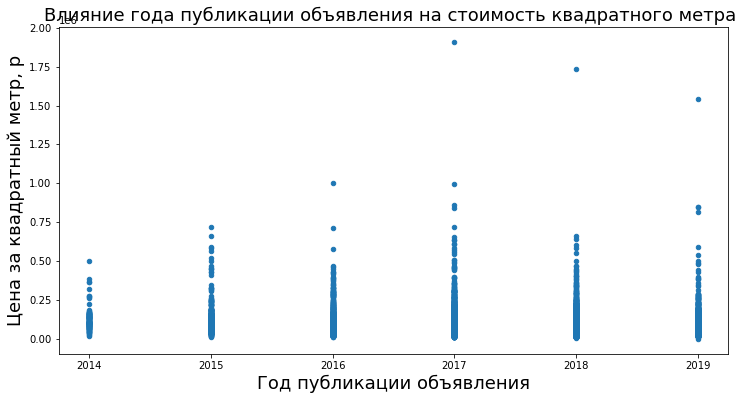

In [91]:
df.plot(x='year',y='square_amount', kind = 'scatter',figsize=(12, 6))
plt.title("Влияние года публикации объявления на стоимость квадратного метра ", fontsize=18)
plt.xlabel("Год публикации объявления", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)


In [92]:
df.groupby(['month']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                             \
               mean    median       min          max       std   
month                                                            
1         99,733.12 95,180.72 12,422.36   556,792.87 45,894.22   
2         98,762.69 95,000.00 10,185.19 1,000,748.13 47,995.20   
3         98,951.99 95,233.27    111.83 1,542,604.80 51,541.81   
4        101,988.11 96,543.70 11,250.00 1,736,842.11 63,412.00   
5         98,488.24 92,696.63 10,897.44   460,000.00 43,221.80   
6         97,795.88 92,857.14  7,962.96   640,422.35 49,221.04   
7         99,613.35 95,005.94 10,507.25   634,328.36 48,809.75   
8        100,109.12 96,052.63  9,615.38   660,000.00 46,025.51   
9        100,519.33 95,623.54 12,555.56 1,907,500.00 59,097.96   
10        97,867.05 94,212.56 14,264.26   995,983.94 45,586.98   
11        99,228.45 95,606.62 10,769.23   658,436.21 42,330.75   
12        99,501.62 94,238.40 12,250.00   719,298.25 52,562.69   

                        
                   var  
month                   
1     2,106,279,061.46  
2     2,303,539,091.37  
3     2,656,558,078.11  
4     4,021,082,283.79  
5     1,868,123,717.93  
6     2,422,710,735.29  
7     2,382,392,063.80  
8     2,118,347,776.81  
9     3,492,568,904.54  
10    2,078,172,373.10  
11    1,791,892,815.25  
12    2,762,836,670.91

Text(0, 0.5, 'Цена за квадратный метр, р')

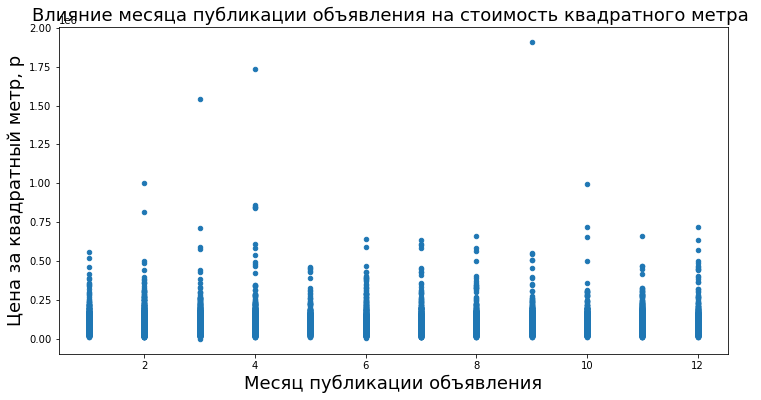

In [93]:
df.plot(x='month',y='square_amount', kind = 'scatter',figsize=(12, 6))
plt.title("Влияние месяца публикации объявления на стоимость квадратного метра ", fontsize=18)
plt.xlabel("Месяц публикации объявления", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)


In [94]:
df.groupby(['weekday']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                             \
                 mean    median       min          max       std   
weekday                                                            
0           99,462.56 94,719.93 10,561.80   857,542.88 46,605.06   
1           99,668.21 95,567.64  7,962.96 1,542,604.80 50,698.71   
2           99,584.73 95,473.81    111.83 1,736,842.11 51,542.99   
3          100,194.72 95,132.92  9,615.38   995,983.94 51,902.11   
4           98,925.00 94,579.90 10,368.66   712,201.49 44,760.99   
5           99,045.85 93,548.39 12,542.37 1,907,500.00 65,711.99   
6           97,759.23 94,594.59 11,463.41   500,000.00 42,652.33   

                          
                     var  
weekday                   
0       2,172,031,693.56  
1       2,570,359,022.86  
2       2,656,680,136.43  
3       2,693,829,259.89  
4       2,003,546,151.84  
5       4,318,065,920.36  
6       1,819,221,217.08

Если посмотреть на среднее значение стоимости квадратного метра в зависимости от дня недели публикации объявления, то зависимости нет

Text(0, 0.5, 'Цена за квадратный метр, р')

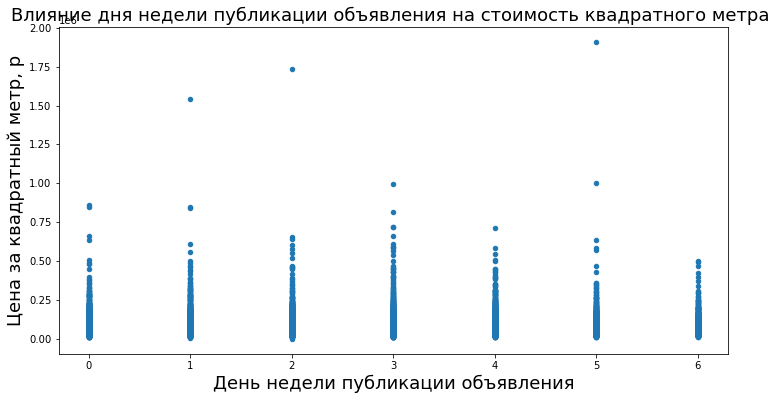

In [95]:
df.plot(x='weekday',y='square_amount', kind = 'scatter',figsize=(12, 6))
plt.title("Влияние дня недели публикации объявления на стоимость квадратного метра ", fontsize=18)
plt.xlabel("День недели публикации объявления", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)


Text(0, 0.5, 'Цена за квадратный метр, р')

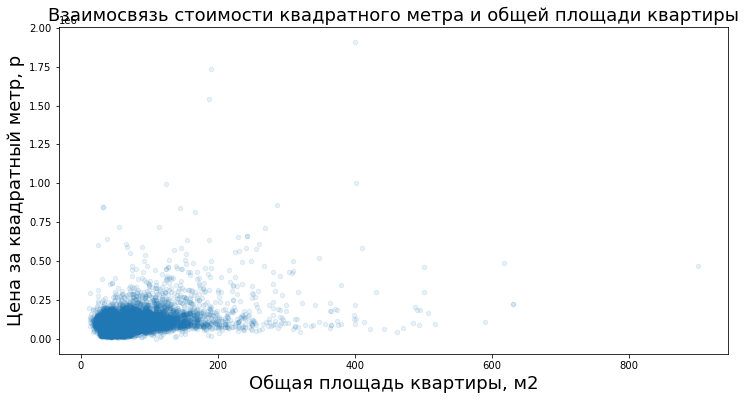

In [96]:
df.plot(x='total_area',y='square_amount', kind = 'scatter',figsize=(12, 6),alpha = 0.1)
plt.title("Взаимосвязь стоимости квадратного метра и общей площади квартиры", fontsize=18)
plt.xlabel("Общая площадь квартиры, м2", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)


Я бы сказала, что цена за квадратный метр не зависит от общей площади квартиры, так как корреляционное поле имеет четкую вытянутость вдоль горизонтальной оси (при параметре alpha = 0.1), если alpha = 1, то корреляционное поле в целом не тяготеет к линейной зависимости. К тому же, коэффициент корреляции между стоимостью за квадрат и общей площадью колеблется от 0,3 до 0,35 (в базе с удаленными пропущенными значениями всеми), что говорит о низкой связи.

Cущественной связи от дня, месяца, года нет. Колебания в стоимости за квадратный метр имеются, но считать их значимыми нельзя.

Text(0, 0.5, 'Цена за квадратный метр, р')

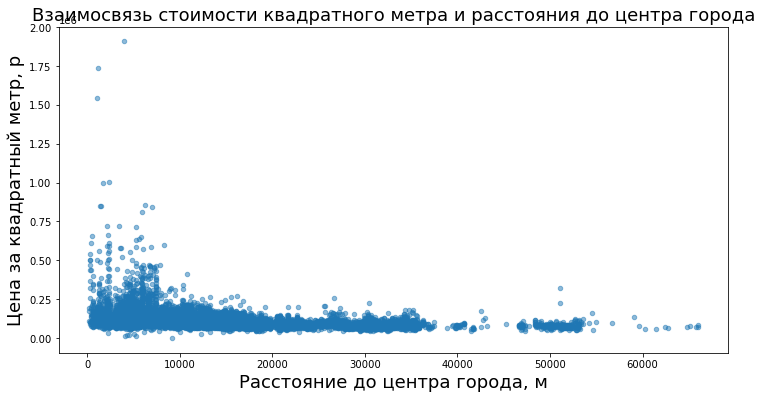

In [97]:
df.plot(x='cityCenters_nearest',y='square_amount', kind = 'scatter',figsize=(12, 6),alpha = 0.5)
plt.title("Взаимосвязь стоимости квадратного метра и расстояния до центра города", fontsize=18)
plt.xlabel("Расстояние до центра города, м", fontsize=18)
plt.ylabel("Цена за квадратный метр, р", fontsize=18)

Сгруппируем по населенному пункту, а в агрегирующих функциях посчитаем количество населенных пунктов и среднюю цену квадратного метра, отсортируем по количеству и покажем топ 10

In [98]:
df_np = df.groupby('locality_name').count().sort_values(by='total_images',ascending=False)
print(df_np['total_images'].head(10))

locality_name
Санкт-Петербург      15651
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: total_images, dtype: int64


In [99]:
place_list = ['Санкт-Петербург','посёлок Мурино','посёлок Шушары', 'Всеволожск',
              'Пушкин','Колпино','посёлок Парголово','Гатчина','деревня Кудрово','Выборг' ]

df.query('locality_name in @place_list').groupby(['locality_name'])['square_amount'].mean().sort_values(ascending=False)


locality_name
Санкт-Петербург     114,868.88
Пушкин              103,125.82
деревня Кудрово      92,473.55
посёлок Парголово    90,175.91
посёлок Мурино       85,673.26
посёлок Шушары       78,551.34
Колпино              75,424.58
Гатчина              68,746.15
Всеволожск           68,654.47
Выборг               58,141.91
Name: square_amount, dtype: float64

Самая высокая стоимость квартир за квадратный метр, ожидаемо, в Санкт-Петербурге, а самая низкая в топ-10, согласно расчетам, в Выборге

Скопируем данные, выделив только квартиры в Санкт-Петербурге:

In [100]:
df_piter = df[df['locality_name']=='Санкт-Петербург']
df_piter

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor,aver_square_per_room
0,20,"13,000,000.00",108.00,2019-03-07,3,2.70,16,51.00,8,False,...,NaN,0.23,0.47,"120,370.37",2019-03-07,2019,3,3,другой,36.00
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5,34.30,4,False,...,558.00,0.15,0.61,"92,785.71",2015-08-20,2015,8,3,другой,28.00
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14,95.00,9,False,...,424.00,0.17,0.60,"408,176.10",2015-07-24,2015,7,4,другой,53.00
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14,32.00,13,False,...,121.00,0.41,0.32,"100,000.00",2018-06-19,2018,6,1,другой,50.00
7,5,"7,915,000.00",71.60,2019-04-18,2,2.65,24,44.30,22,False,...,NaN,0.26,0.62,"110,544.69",2019-04-18,2019,4,3,другой,35.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,"3,550,000.00",35.30,2018-02-28,1,2.86,15,16.30,4,False,...,29.00,0.26,0.46,"100,566.57",2018-02-28,2018,2,2,другой,35.30
23690,3,"5,500,000.00",52.00,2018-07-19,2,2.65,5,31.00,2,False,...,15.00,0.12,0.60,"105,769.23",2018-07-19,2018,7,3,другой,26.00
23691,11,"9,470,000.00",72.90,2016-10-13,2,2.75,25,40.30,7,False,...,519.00,0.15,0.55,"129,903.98",2016-10-13,2016,10,3,другой,36.45
23694,9,"9,700,000.00",133.81,2017-03-21,3,3.70,5,73.30,3,False,...,NaN,0.10,0.55,"72,490.85",2017-03-21,2017,3,1,другой,44.60


Судя по переменной cityCenters_nearest, расстояние до центра дано в метрах , переведем его в километры:

In [101]:
df_piter.dropna(inplace = True)
df_piter.loc[:,'centers_int'] = round(df_piter.loc[:,'cityCenters_nearest'] / 1000).astype('int')

df_piter['centers_int'] 

2        14
3         7
4         8
10       14
15       14
         ..
23673    12
23681     7
23686    12
23689    16
23697    10
Name: centers_int, Length: 3568, dtype: int32

In [102]:
df_piter

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor,aver_square_per_room,centers_int
2,10,"5,196,000.00",56.00,2015-08-20,2,2.65,5,34.30,4,False,...,0.15,0.61,"92,785.71",2015-08-20,2015,8,3,другой,28.00,14
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14,95.00,9,False,...,0.17,0.60,"408,176.10",2015-07-24,2015,7,4,другой,53.00,7
4,2,"10,000,000.00",100.00,2018-06-19,2,3.03,14,32.00,13,False,...,0.41,0.32,"100,000.00",2018-06-19,2018,6,1,другой,50.00,8
10,5,"5,050,000.00",39.60,2017-11-16,1,2.67,12,20.30,3,False,...,0.21,0.51,"127,525.25",2017-11-16,2017,11,3,другой,39.60,14
15,16,"4,650,000.00",39.00,2017-11-18,1,2.65,14,20.50,5,False,...,0.19,0.53,"119,230.77",2017-11-18,2017,11,5,другой,39.00,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23673,9,"3,100,000.00",23.00,2018-03-19,1,2.80,9,12.60,1,False,...,0.22,0.55,"134,782.61",2018-03-19,2018,3,0,первый,23.00,12
23681,13,"5,250,000.00",43.00,2018-05-11,2,2.50,5,29.00,2,False,...,0.14,0.67,"122,093.02",2018-05-11,2018,5,4,другой,21.50,7
23686,8,"3,300,000.00",31.00,2017-04-29,1,2.55,9,18.00,6,False,...,0.21,0.58,"106,451.61",2017-04-29,2017,4,5,другой,31.00,12
23689,13,"3,550,000.00",35.30,2018-02-28,1,2.86,15,16.30,4,False,...,0.26,0.46,"100,566.57",2018-02-28,2018,2,2,другой,35.30,16


Сгруппируем и посчитаем среднюю стоимость квадратного метра для каждого километра

In [103]:
df_piter_av_amount_per_km = df_piter.groupby(['centers_int'])['square_amount'].mean()

In [104]:
df_piter_av_amount_per_km

centers_int
0    226,876.50
1    169,004.49
2    158,367.42
3    120,409.10
4    145,220.73
5    136,133.12
6    157,991.52
7    181,629.13
8    133,870.27
9    123,125.21
10   118,188.99
11   116,330.27
12   107,244.89
13   103,091.93
14    99,525.48
15    98,657.19
16    97,628.61
17   109,024.62
18    92,322.80
19   106,196.03
20   108,649.64
21    78,301.51
22    92,450.74
25    92,237.24
26    89,568.79
28    68,473.36
Name: square_amount, dtype: float64

Построим график зависимости стоимости квадратного метра от удаленности от центра в километрах. Очевидно, что чем дальше от центра, тем дешевле квартиры в пересчете на квадрат. 
Предполагаю, что точка смены "центральная зона" на "удаленное от центра жилье" это примерно 7 км (из таблицы выше), тк при расстоянии 7 км происходит сильный перепад от 180 тысяч за квадрат до 130 тысяч. И далее происходит уже постепенное снижение стоимости квадрата жилья (в то время как для цен в диапазоне до 7 км от центра характерен сильный разброс значений)

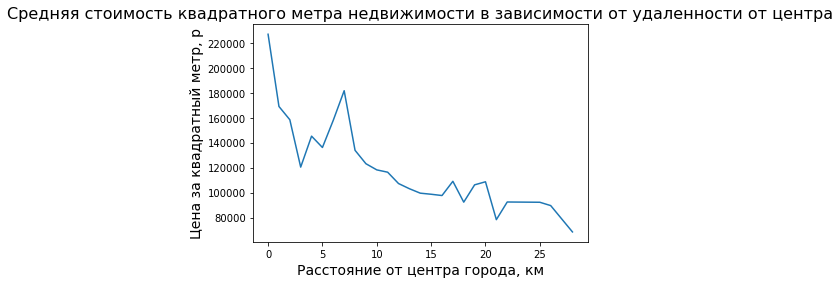

In [105]:
df_piter_av_amount_per_km.plot()
plt.title("Средняя стоимость квадратного метра недвижимости в зависимости от удаленности от центра", fontsize=16)
plt.xlabel("Расстояние от центра города, км", fontsize=14)
plt.ylabel("Цена за квадратный метр, р", fontsize=14)

plt.show()

In [106]:
df_piter_centre = df_piter[df_piter['centers_int']<= 7 ]
df_piter_centre

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_part,living_part,square_amount,first_day,year,month,weekday,what_floor,aver_square_per_room,centers_int
3,0,"64,900,000.00",159.00,2015-07-24,3,2.65,14,95.00,9,False,...,0.17,0.60,"408,176.10",2015-07-24,2015,7,4,другой,53.00,7
24,8,"6,500,000.00",97.20,2015-10-31,2,2.65,3,46.50,1,False,...,0.20,0.48,"66,872.43",2015-10-31,2015,10,5,первый,48.60,2
63,2,"20,000,000.00",118.00,2018-09-11,3,3.00,9,68.00,7,False,...,0.14,0.58,"169,491.53",2018-09-11,2018,9,1,другой,39.33,5
136,16,"6,500,000.00",51.80,2018-08-01,2,3.45,6,25.60,2,False,...,0.14,0.49,"125,482.63",2018-08-01,2018,8,2,другой,25.90,4
137,11,"13,310,800.00",85.10,2018-01-01,2,2.70,10,31.52,5,False,...,0.32,0.37,"156,413.63",2018-01-01,2018,1,0,другой,42.55,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23644,7,"4,990,000.00",62.50,2018-04-26,2,2.70,4,32.30,4,False,...,0.19,0.52,"79,840.00",2018-04-26,2018,4,3,последний,31.25,4
23648,14,"10,100,000.00",78.00,2017-05-12,3,3.27,5,48.60,5,False,...,0.11,0.62,"129,487.18",2017-05-12,2017,5,4,последний,26.00,1
23664,5,"9,000,000.00",110.00,2015-12-10,4,3.36,7,64.60,5,False,...,0.14,0.59,"81,818.18",2015-12-10,2015,12,3,другой,27.50,5
23665,11,"4,250,000.00",47.00,2016-05-20,1,2.65,6,18.20,1,False,...,0.31,0.39,"90,425.53",2016-05-20,2016,5,4,первый,47.00,5


<AxesSubplot:>

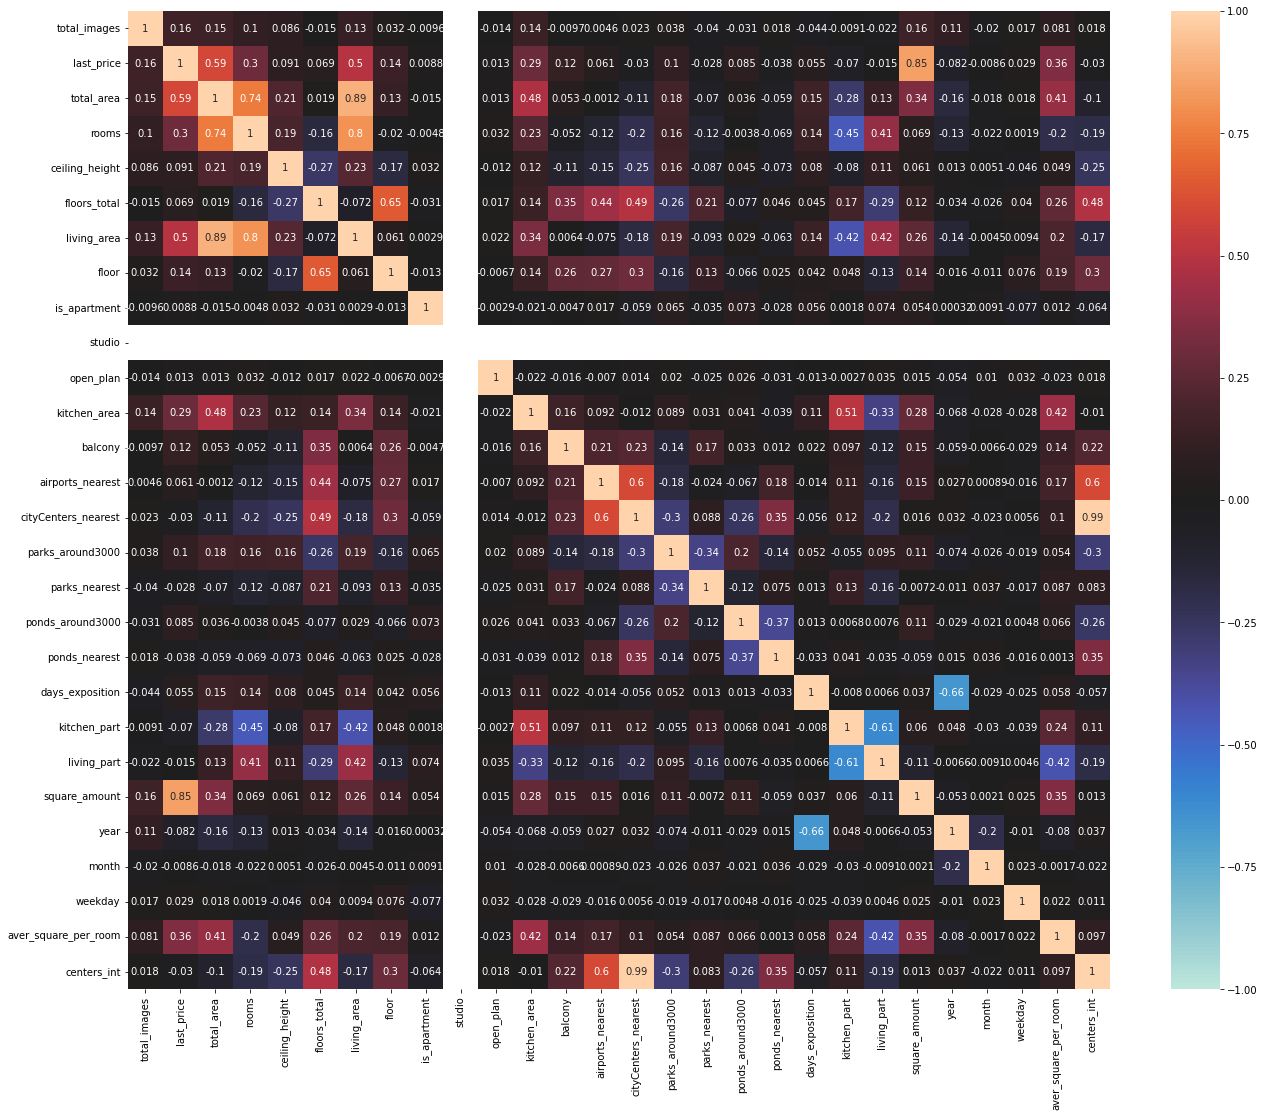

In [107]:
plt.figure(figsize=(22, 18))
sb.heatmap(df_piter_centre.corr(),annot = True,fmt='.2g',vmin=-1, vmax=1, center= 0)

Судя по корреляционной матрице, на стоимость квартир в центре сильнее всего влияют общая площадь (чем больше, тем выше цена), количество парков и прудов (но связь очень очень слабая). Дата публикации не влияет на стоимость, как и удаленность от центра, но это и понятно, в центре города квартиры востребованы независимо от сезона. Они просто востребованы)

In [108]:
df_piter_centre.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,"1,362.00",10.27,6.18,0.00,6.00,10.00,15.00,50.00
last_price,"1,362.00","16,260,411.41","31,525,034.35","1,600,000.00","6,560,000.00","9,100,000.00","15,000,000.00","763,000,000.00"
total_area,"1,362.00",92.15,55.01,12.00,56.73,79.00,109.00,500.00
rooms,"1,362.00",2.84,1.38,1.00,2.00,3.00,4.00,14.00
ceiling_height,"1,362.00",2.94,0.37,2.40,2.65,2.80,3.20,4.90
floors_total,"1,362.00",6.60,3.10,2.00,5.00,6.00,8.00,25.00
living_area,"1,362.00",53.95,34.79,3.00,31.00,46.40,65.00,312.50
floor,"1,362.00",3.95,2.58,1.00,2.00,3.00,5.00,21.00
kitchen_area,"1,362.00",14.20,9.09,2.00,8.91,11.20,16.50,107.00
balcony,"1,362.00",0.29,0.72,0.00,0.00,0.00,0.00,5.00


сделаем табличку, содержащую средние значения в целом по данным, и только по квартирам, которые относятся к центральной зоне. Из таблички можно сделать выводы, что средняя цена за квартиру отличается значительно (6 миллионов против 16 миллионов), отличается общая площадь - в среднем квартиры в центре больше на 32 квадрата, и количество комнат - трехкомнатные в центре и двухкомнатные в среднем по всем данным.
Потолки в центре выше (2.94 против 2.77, в таблице ниже просто округление до целого), дома меньшей этажности (7 против 11), больше площадь у кухонь, ближе аэропорты, и продаются квартиры в центре дольше, чем в целом по таблице (250 дней против 180 в среднем).
Также сильно отличается цена за квадратный метр (около 150 тысяч в центре и около 100 тысяч в целом) и в целом комнаты в центре чуть чуть больше, чем в целом по квартирам

Насколько достоверны эти различия, я пока не могу сказать, тк различия могут быть статистически значимыми или нет((( 


In [109]:
df_compare =  pd.concat([df.mean().round().rename('general'), df_piter_centre.mean().round().rename('central_zone')], axis=1)
df_compare

,general,central_zone
total_images,10.00,10.00
last_price,"6,540,058.00","16,260,411.00"
total_area,60.00,92.00
rooms,2.00,3.00
ceiling_height,3.00,3.00
floors_total,11.00,7.00
living_area,34.00,54.00
floor,6.00,4.00
is_apartment,0.00,0.00
studio,0.00,0.00


In [110]:
df_piter_centre.groupby(['what_floor']).agg({'square_amount':['mean', 'median','min', 'max', 'std', 'var']})

square_amount                                               \
                    mean     median       min          max        std   
what_floor                                                              
другой        159,612.56 130,985.92 26,250.00 1,736,842.11 112,302.95   
первый        119,075.71 107,418.80 17,391.30   390,625.00  51,977.18   
последний     148,166.93 115,849.06 66,835.87 1,907,500.00 146,349.21   

                              
                         var  
what_floor                    
другой     12,611,953,606.61  
первый      2,701,626,887.92  
последний  21,418,091,662.14

In [111]:
df_what_floor =  pd.concat([df.groupby(['what_floor']).agg({'square_amount':['mean']}), 
                            df_piter_centre.groupby(['what_floor']).agg({'square_amount':['mean']})], axis=1)
df_what_floor

square_amount           
                    mean       mean
what_floor                         
другой        103,486.32 159,612.56
первый         82,001.61 119,075.71
последний      93,378.96 148,166.93

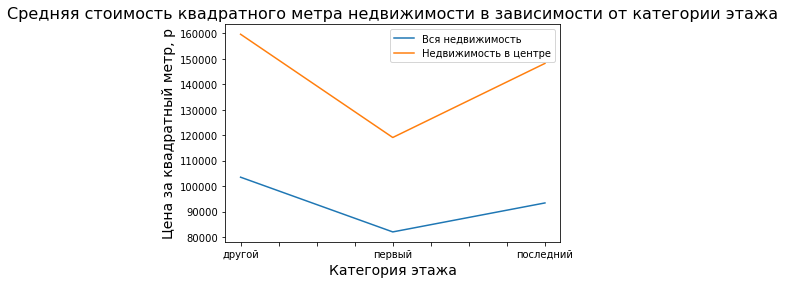

In [112]:
df_what_floor.plot()
plt.title("Средняя стоимость квадратного метра недвижимости в зависимости от категории этажа", fontsize=16)
plt.xlabel("Категория этажа", fontsize=14)
plt.ylabel("Цена за квадратный метр, р", fontsize=14)
plt.legend(['Вся недвижимость', 'Недвижимость в центре'])
plt.show()

Общий характер сохраняется для всей таблицы и квартир в центре города, что самая высокая цена за квадрат на средних этажах, а самая низкая на 1 этаже

# Общие выводы

Была проанализирована база данных Яндекс.Недвижимость за 2014- 2019 годы. Были проанализированы допущенные пропуски в данных, и устранены по возможности. К сожалению, заполнить все пропуски не было возможно, так как не у всех объявлений были заполнены данные о количестве прудов, парков, расстояние до центра.

В среднем продажа квартиры, согласно этим данным, занимала 180 дней, но при этом самое частое наблюдение составило 45 дней - столько чаще всего существовало объявление о продаже квартиры.

Больше всего влияют на стоимость квадратного метра недвижимости площадь квартиры, нахождение квартиры в центре города, нахождение квартиры на средних этажах, наличие неподалеку водоемов и парков. Время публикации (день недели, месяц года) не влияют на стоимость квадратного метра. Год публикации в целом влияет, но тут нет прямой зависимости, и скорее необходимо учитывать социально-экономические факторы и текущие события, происходящие в стране (колебания курсов валют, крупные политические события, социальные потрясения), зависимости от номера года нет.

По результатам количества объявлений посчитаны населенные пункты с наибольшим количеством объявлений. Самая дорогая недвижимость в первой десятке это Санкт-Петербург , Пушкин (от 103 тысяч рублей за квадратный метр), самая дешевая в первых топ-10 это Всеволожск и Выборг (до 68 тысяч рублей за квадратный метр)

Изучена удаленность квартир от центра города, согласно переменной "расстояние до центра города", изучена зависимость стоимости квадратного метра жилья от удаленности от центра. Выделен сегмент квартир "в центре города", у которых стоимость квадратного метра резко отличается от квартир, более удаленных. Таким образом, радиус центра города составляет примерно 7 километров.

На квартиры, расположенные в центре, влияют в основном на стоимость все те же факторы, что и на квартиры в целом в базе, например общая площадь (больше на 32 кв.м.в среднем) и  наличие парков, прудов в зоне досягаемости, при этом в целом квартиры, относящиеся к "центру", отличаются более низкой этажностью застройки (7 против 11), более высокими потолками (2.94 против 2.77), большими площадями, чуть большей близостью к аэропорту и большей площадью кухонь. При этом квартиры в центре продаются гораздо медленнее (250 дней против 180), возможно в первую очередь из-за того, что цена продажи значительно отличается от средней по базе (6 миллионов против 16 миллионов)
